# Problem 1

Under assumptions of Amdahl's law, suppose that 60% of a program are perfectly parallelizable, and the rest is not parallelizable. What is the maximum speedup achievable by parallelization? What will be the efficiency of parallelization at 2-fold speedup?


**Answer:**

* Amdahl's law is $S_p = \frac{1}{\alpha + \frac{1-\alpha}{p}}$, where $\alpha$ is coefficient that shows the amount of non parallelized part of program. The Maximum of speedup can be achieved when the number of processes $p$ is infinity. Thus, $\tilde {S_p} = \frac{1}{\alpha}$, where $\alpha = 0.4$. It gives us  $\tilde {S_p} = 2.5$.

* For 2-fold speedup ($S_p = 2$) we need express $p = \frac{\alpha -1}{\alpha - \frac{1}{S_p}} = \frac{0.4 -1}{0.4 - 0.5}  = 6$. Thus, efficiency of parallelization is equal to $\frac{2}{6} = \frac{1}{3}$.


# Problem 2

Write a Python or C/C++ program that uses MPI reduce to find the largest file in terms of the number of lines among all .txt files in the working directory. The program must be callable in the form mpirun -np <N> python linecount.py (in the case of the Python version) or mpirun -np <N> linecount.exe (the C/C++ version), where <N> is the user-defined number of processes. The program is expected to first somehow distribute the files found in the current directory to the processes, then each process should count the lines in the files assigned to it, and finally the result should be MPI-reduced and printed out.

In [1]:
import os
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD 
rank = comm.Get_rank() 
size = comm.Get_size()

directory = 'files/'

if rank == 0:
    files = os.listdir(directory)[1:]
    chunks = [files[i : len(files) : size] for i in range(size)]
else:
    chunks = None

chunk = comm.scatter(chunks, root = 0)
text_size = -1
text_name = ''

# Possible modifications:
#  - If I have 2 files with the same length?
#  - Do I need calculate as row If I have only '\n' symbol?
for unit in chunk:
    i = 0
    with open(directory + unit) as file:
        for line in file:
            i += 1
    if i > text_size: 
        text_size = i
        text_name = unit

largestFile = comm.reduce([text_size, text_name], op = MPI.MAXLOC, root = 0)    

if rank == 0:
    print ('Max size : ', largestFile)

('Max size : ', [34, '6.txt'])


# Problem 3

Solve the Distinct Substrings problem at Sphere online judge: http://www.spoj.com/problems/DISUBSTR/. Provide code passing the test of the judge. Explain how your code works and theoretically estimate the complexity of the algorithm (as  $O(f(N)$), where  $f(N)$ is some function of the length of the input string).

In [2]:
import numpy as np
import sys

def invPerm(p):
    'Invert the permutation p'
    s = np.empty(p.size, p.dtype)
    s[p] = np.arange(p.size)
    return s

def getSA(A):
    if not type(A) is np.ndarray:
        A = np.array(list(A))
    N = len(A) 
    M = int(np.ceil(np.log2(N)))+1   # number of iterations
    P = np.zeros((M,N), dtype=int) 
    Q = np.zeros((M,N), dtype=int)     
    R = np.zeros((M,3*N), dtype=int) 

    for k in range(M):
        if k == 0:
            P[0] = np.argsort(A)
            Q[0][1:] = np.cumsum(A[P[0]][1:] != A[P[0]][:-1])
            R[0][:N] = Q[0][invPerm(P[0])]
        else:
            offset = 2**(k-1)
            r = np.lexsort((R[k-1, P[k-1]+offset], R[k-1, P[k-1]]))
            P[k] = P[k-1][r]  
            Q[k][1:] = np.cumsum(np.logical_or(R[k-1][P[k]][1:] != R[k-1][P[k]][:-1], 
                                          R[k-1][P[k]+offset][1:] != R[k-1][P[k]+offset][:-1]))
            R[k][:N] = Q[k][invPerm(P[k])]

            if Q[k][-1] == N-1: 
                break

    SA = P[k]
    return SA, P[:k+1], Q[:k+1], R[:k+1]  

def getLCP(SA, R):
    (M, N) = R.shape
    LCP = np.zeros((len(SA)-1,),dtype=int)
    for m in range(M-1)[::-1]:
        t = (R[m][SA[1:]+LCP] == R[m][SA[:-1]+LCP]).astype(int)
        LCP += (2**m)*t
    return LCP


def main():
    number = int(raw_input())
    data = []
    for i in range(number):
        data.append(sys.stdin.readline().upper().rstrip('\n') + '$')

    for i in range(number):
        A = data[i]
        SA, _, _, R = getSA(A)
        LCP = getLCP(SA, R)

    print((len(A) - 1 - SA).sum()- LCP.sum())

if __name__ == '__main__':
    main()  


2
0


* getSA and getLCP was developed on seminars. For finding the number of Distinct Substrings I have calculated the following formula:
$\sum_{i=0}^{n} (n - 1 -SA[i])$ - $\sum_{i=0}^{n-1} (LCP[i])$


* Get Suffix Array - SA algorithm
* Find the largest prefix of pairs in Suffix Array - LCP algorithm 
* Calculate number of the above formula

Note: the first part means that all possible substrings that can be produced and the second part means repeats of previous string. In other words it means the difference between new string and previous.

The complexity of the algorithm is O(Nlog^2N) as was shown on the seminar. 


# Problem 4

Suppose that we want to distribute  $N$ personal projects to $N$ students. Assume that each student  $(k)^{N−1}_{k=0}$ has a list of his/her preferences for the projects, expressed as a vector  $r_k$
  of integer ranks assigned to each project. Ranks vary between 0 and  N−1
  without repetitions, the **lower** the rank the more **preferable** the project. (For example, the first student's ranks are  $r_0=[2,1,0]$
 , the second's  $r_1=[0,2,1]$
  and the third  $r_2=[0,1,2]$). We want to distribute the projects so as to maximize the total preference, i.e., if  $n_k$
  denotes the project assigned to the  $k$
 'th student, we want to make  $f=\sum^{N−1}_{k=0}r_k[n_k]$
  as small as possible. (In the example above the optimal distribution is  $n_0=2$,$n_1=0$,$n_2=1$
 , which gives  $f=1$)
 
* Come up with an algorithm optimizing the distribution and implement it in a Python or C/C++ program. The algorithm should accept the preference vectors and output a recommended distribution  $(n_k)^N_k=1$
 . The algorithm need not find the best solution, but is expected to generally produce better solutions than would have been obtained by randomly distributing the projects. The algorithm should be reasonably fast, say run in not more than a few seconds for  $N=30$
 
* Compare experimentally your algorithm with the trivial algorithm producing a random distribution. To this end, perform  $M=1000$
  experiments in each of which 1) random preference vectors for  $N=30$
  students and projects are generated; 2) the objective function  $f$
  is evaluated for both algorithms. After finishing all the experiments, plot the two respective distributions of the obtained  $M$
  values of  $f$
  and compute the mean values of  $f$
  for both algorithms.


Random Generator:
Improvements Heuristic algorithm in 7.6 times from Random
Improvements Munkres algorithm in 19.0 times from Random

Special Generator:
Improvements Heuristic algorithm in 4.5 times from Random
Improvements Munkres algorithm in 7.3 times from Random


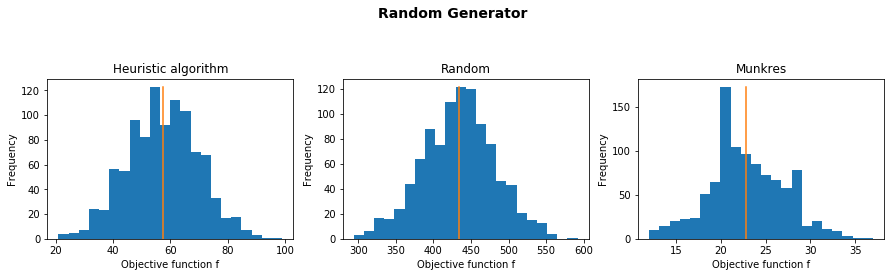

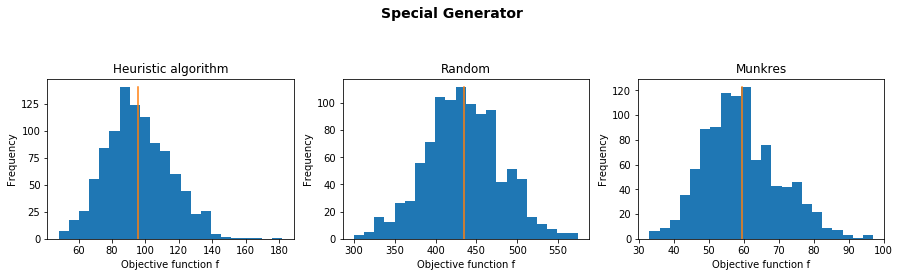

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from munkres import Munkres, print_matrix
%matplotlib inline

def testRandomGenerator(N):
    table = []
    for i in range(N):
        table.append(random.sample(range(N), N))
    return table

def testGenerator_repeats(N, repeats=0.5):
    uniqueN = int(N * (1 - repeats))
    table = []
    
    sample = np.random.normal(0, 1, N)
    distr_of_uniqueN = np.histogram(sample, bins = uniqueN)[0]
    
    for number in distr_of_uniqueN:
        if number > 0:
            s = random.sample(range(N), N)
            for i in range(number):
                table.append(s)
                
    return random.sample(table, N)

def calcRandomly(N, A):
    x = random.sample(range(N), N)        
    y = random.sample(range(N), N)
    sums = 0
    for x_i, y_i in zip(x, y):
        sums += A[x_i][y_i]

    return sums

def algorithm(N, A):
    set_of_arrays = set([i for i in range(N)])
    values = [-1 for i in range(N)]
    j = 0

    while len(set_of_arrays) > 0:
        selectedArrays = []

        for arr in list(set_of_arrays):
            pos = A[arr].index(j) # find a position
            if values[pos] == -1: # fill if it is free
                values[pos] = j
                selectedArrays.append(arr)

        set_of_arrays -= set(selectedArrays)
        j += 1
    return np.sum(values)

def Munk(A):
    m = Munkres()
    indexes = m.compute(A)
    total = 0
    for row, column in indexes:
        value = A[row][column]
        total += value

    return total
    

data1 = [[], []]
data2 = [[], []]
data3 = [[], []]
N = 30
A = [[], []]
for i in range(1000):
    A[0] = testRandomGenerator(N)
    A[1] = testGenerator_repeats(N, repeats=0.3)
    
    data1[0].append(algorithm(N, A[0]))
    data2[0].append(calcRandomly(N, A[0]))
    data3[0].append(Munk(A[0]))
    
    data1[1].append(algorithm(N, A[1]))
    data2[1].append(calcRandomly(N, A[1]))
    data3[1].append(Munk(A[1]))
    
mean1 = np.mean(data1, axis=1)
mean2 = np.mean(data2, axis=1)
mean3 = np.mean(data3, axis=1)
    
fig1 = plt.figure(figsize=(15,10))
fig1.suptitle('Random Generator', fontsize=14, fontweight='bold')
ax1 = fig1.add_subplot(331)
plt.title('Heuristic algorithm')
n, _, _ = ax1.hist(data1[0], bins=22)
plt.plot([mean1[0]]*200, np.linspace(0, n.max(), 200))
ax1.set_xlabel('Objective function f')
ax1.set_ylabel('Frequency')

ax2 = fig1.add_subplot(332)
plt.title('Random')
n, _, _ = ax2.hist(data2[0], bins=22)
plt.plot([mean2[0]]*200, np.linspace(0,n.max(), 200))
ax2.set_xlabel('Objective function f')
ax2.set_ylabel('Frequency')

ax3 = fig1.add_subplot(333, label='r')
plt.title('Munkres')
n, _, _ = ax3.hist(data3[0], bins=22)
plt.plot([mean3[0]]*200, np.linspace(0,n.max(), 200))
ax3.set_xlabel('Objective function f')
ax3.set_ylabel('Frequency')

print 'Random Generator:'
print 'Improvements Heuristic algorithm in', round(np.mean(data2[0]) / np.mean(data1[0]),1), 'times from Random'
print 'Improvements Munkres algorithm in', round(np.mean(data2[0]) / np.mean(data3[0]),1), 'times from Random'

fig2 = plt.figure(figsize=(15,10))
fig2.suptitle('Special Generator', fontsize=14, fontweight='bold')
ax1 = fig2.add_subplot(331)
plt.title('Heuristic algorithm')
n, _, _ = ax1.hist(data1[1], bins=22)
plt.plot([mean1[1]]*200, np.linspace(0, n.max(), 200))
ax1.set_xlabel('Objective function f')
ax1.set_ylabel('Frequency')

ax2 = fig2.add_subplot(332)
plt.title('Random')
n, _, _ = ax2.hist(data2[1], bins=22)
plt.plot([mean2[1]]*200, np.linspace(0,n.max(), 200))
ax2.set_xlabel('Objective function f')
ax2.set_ylabel('Frequency')

ax3 = fig2.add_subplot(333, label='r')
plt.title('Munkres')
n, _, _ = ax3.hist(data3[1], bins=22)
plt.plot([mean3[1]]*200, np.linspace(0,n.max(), 200))
ax3.set_xlabel('Objective function f')
ax3.set_ylabel('Frequency')

print '\nSpecial Generator:'
print 'Improvements Heuristic algorithm in', round(np.mean(data2[1]) / np.mean(data1[1]),1), 'times from Random'
print 'Improvements Munkres algorithm in', round(np.mean(data2[1]) / np.mean(data3[1]),1), 'times from Random'

What is here?:
* Seveloped simple heuristic algorithm that approximately calculate the minimum of the objective function. 
* Showed the difference with Munkres algorithm (or Hungarian algorithm)
* Developed the special Generator

My heuristic algorithm:
1. I find all zeros in recommendations
2. If I have a collision in columns, then I choose only one number. Thus it gives partly-filled array.
3. I find all ones in reccommendations among the rest columns
4. If I have a collision in columns, then I choose only one number. Thus it gives almost filled array.
5. I continue this process untill I fill all gaps

Obviously, It takes $O(N^3)$, because I need to find $N$ values in $N^2$ table no more than N times

# Problem 5

Suppose that we have developed an algorithm that is supposed to generate independent (quasi-)random numbers uniformly distributed in the interval  $[0,1]$
 . To test our algorithm, we perform a series of experiments. In each experiment, we generate  N=103
  numbers  $(x_n)^N_{n=1}$
  with our algorithm, and compute the minimum distance  $r=\min_{1\leq n < m \leq N}|x_n−x_m|$
  between them. We observe that in more than 90% of such experiments we obtain  $r<10^{−5}$
 . Does this observation contradict the hypothesis of generating independent uniformly distributed random numbers? Explain your answer.

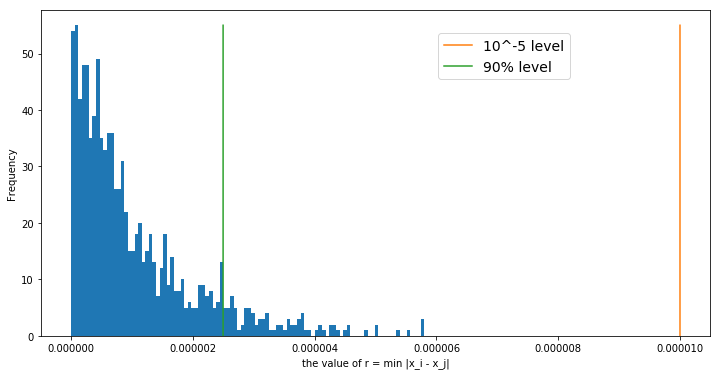

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def generator(size = 100, length=1000):
    for i in range(size):
        yield np.random.uniform(size=length)

def getMin(values):
    values.sort()
    rmin = 1e8
    for ind, num in enumerate(values[1:]):
        if num - values[ind] < rmin:
            rmin = num - values[ind]

    return rmin

def get90percentValue(n, bins, size):
    summ = 0
    for i, val in enumerate(n):
        if 0.9 * size < summ:
            break
        else:
            summ += val
    return bins[i]
    
size = 1000
results = []
for values in generator(size):
    val = getMin(values)
    results.append(val)

plt.figure(figsize=(12,6))
n, bins, _ = plt.hist(results, bins=100)
plt.plot([1e-5]*2000, np.linspace(0,n.max(), 2000), label = '10^-5 level')
plt.plot([get90percentValue(n, bins, size)]*2000, np.linspace(0,n.max(), 2000), label = '90% level')
plt.xlabel('the value of r = min |x_i - x_j|')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(0.8, 0.95), prop={'size': 14})
plt.show()

In this experiment I showed what results of uniform distribution. The orange line is our requirement. The Green line - is 90% level. We see that green line is left than orange line, thus our requirement is satisfied.

BUT! At the same time we **can't say** that all samples with this requirement (r < 1e-5) are uniform. Below I will show the distribution, that always satisfy this requirement, but the tests for continuous distributions is **never accepted** (i.e. the distribution is not uniform)!

**Kolmogorov-Smirnov test:** $H_0$ is rejecting $\Leftrightarrow D_n \geq t_\alpha, \; P(D_n \geq t_\alpha | H_0) = \alpha$, where $D_n = \sup_x |\hat{F_n}(x) - F(x)|$

Here we suppose that Significance level is 10%. Thus quantile on 1-a level is 1.22

In [5]:
def getSample(N = 1000):
    sample = np.array([np.random.randn() for i in range(N)])
    sample = (sample - sample.min()) / (sample.max() - sample.min())
    return sample

def checkKolmogorov(sample):
    sample.sort()
    Fn = [1.0 * i / len(sample) for i in range(len(sample))]
    value = np.abs(Fn - sample).max() * np.sqrt(len(sample))
    
    # alpha = 10% - Significance level
    if value < 1.22:
        return 1
    
    return 0

success = 0
size = 100
results = []
for ex in range(size):
    sample = getSample()
    results.append(checkKolmogorov(sample))
    sample.sort()
    num = 0
    for i, value in enumerate(sample[1:]):
        if value - sample[i] < 1e-5:
            num += 1
    if num > 0:
        success += 1
        
print 'In all experiments the min distance is achieved - r < 1e-5: ', success * 1.0 / size
print 'At the same time the Kolmogorov-Smirnov test is rejected for all experiments:', np.mean(results)
print 'Although it works for uniform distribution: ', checkKolmogorov(np.random.uniform(size=1000)), '- accepted'
    

In all experiments the min distance is achieved - r < 1e-5:  1.0
At the same time the Kolmogorov-Smirnov test is rejected for all experiments: 0.0
Although it works for uniform distribution:  1 - accepted


It means that the distribution is not uniform, but requerements is achieved! 